<a href="https://colab.research.google.com/github/kibutan/signate/blob/main/Signate_409_%E6%A0%AA%E4%BE%A1%E3%81%AE%E6%8E%A8%E7%A7%BB%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

株価予測コンペ

時系列で、使わない特徴量が無いと思う。
前日の影響がどれだけあるかとか、何日前までの影響があるかとかといった設定が重要なものではないか？
RNNを使うのか？

→RNNを使うし、LSTMを使う。
Dropoutも使う

In [ ]:
%pip install signate

     |████████████████████████████████| 143kB 12.8MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=14e26436b9aab34bfb0ca0dd46ffb2630ebd77e956b3e4d274659d5c50d44011
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
#kaggle.jsonをGoogle Drive からひっぱってくるやつ
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [ ]:
!signate list

  competitionId  title                                                              closing     prize                             submitters
---------------  -----------------------------------------------------------------  ----------  ------------------------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                               -                                                   4258
             24  【練習問題】お弁当の需要予測                                       -                                                   5094
             27  【練習問題】Jリーグの観客動員数予測                                -                                                   1109
            100  【練習問題】手書き文字認識                                         -           Knowledge                                111
            102  【練習問題】タイタニックの生存予測                                 -           Knowledge                                417
            103  【練習問題】音楽ラベリング                                         -           Knowledge

In [ ]:
#規約同意前ならエラーを返す。yを入力後再実行でダウンロードが可能に。
#指定しない限り、カレントディレクトリにデータは降りる。
!signate download -c 409

sample_submission.csv

test.csv

train.csv


Download completed.


In [ ]:
!ls

adc.json  sample_data  sample_submission.csv  test.csv	train.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout

In [ ]:
train =  pd.read_csv("train.csv",index_col="Date",parse_dates=True)
test = pd.read_csv("test.csv",index_col="Date",parse_dates=True)
submit = pd.read_csv("sample_submission.csv",names  = ("Date","Up"),index_col="Date",parse_dates=True)

In [ ]:
print(train.shape)
print(test.shape)
print(submit.shape)


(2026, 7)
(1200, 6)
(200, 1)


In [ ]:
# train =  pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")
# submit = pd.read_csv("sample_submission.csv",names  = ("Date","Up"))

# df["Date"] = pd.to_datetime(train["Date"])

In [ ]:
train.dtypes

Open     float64
High     float64
Low      float64
Close    float64
Up         int64
dtype: object

In [ ]:
train.tail()

,Open,High,Low,Close,Up
Date,,,,,
2012-01-11,108.62,109.00,108.41,108.86,1
2012-01-12,109.68,109.90,109.44,109.83,0
2012-01-13,109.53,109.72,109.08,109.66,1
2012-01-17,109.99,110.47,109.57,109.96,1
2012-01-18,110.06,110.82,109.94,110.58,0


In [ ]:
test.head()

,Open,High,Low,Close
Date,,,,
2012-01-19,110.79,110.82,109.96,110.39
2012-01-20,110.45,111.10,110.36,110.73
2012-01-23,110.95,111.10,109.65,110.36
2012-01-24,110.16,110.16,108.13,108.39
2012-01-25,106.25,107.11,105.97,106.89


In [ ]:
submit.head()

,Up
Date,
2012-01-26,0
2012-02-09,0
2012-02-24,0
2012-03-09,0
2012-03-23,0


In [ ]:
print(train.shape,test.shape,submit.shape)

(2026, 5) (1200, 4) (200, 1)


In [ ]:
print(train.dtypes)
print()
print(test.dtypes)
print()
print(submit.dtypes)

Open     float64
High     float64
Low      float64
Close    float64
Up         int64
dtype: object

Open     float64
High     float64
Low      float64
Close    float64
dtype: object

Up    int64
dtype: object


# DateがObjectで読み込まれているところ、Upがintで読み込まれているところが気になる。

train =  pd.read_csv("train.csv",index_col="Date",parse_dates=True)
test = pd.read_csv("test.csv",index_col="Date",parse_dates=True)
submit = pd.read_csv("sample_submission.csv",names  = ("Date","Up"),index_col="Date",parse_dates=True)

index_colで指定したDate行をparse_dates=Trueとすることで日時データであると認識させた。これだとフォーマット指定が違う形で読まれるので、おbジェCTとして読ませてから変換する形をとる。

数字の精査
まずはisnull().sum()かと。
次にDescribe()かと思ったが.




In [ ]:
print(train.isnull().sum())
print()
print(test.isnull().sum())
print()
print(submit.isnull().sum())

Open     0
High     0
Low      0
Close    0
Up       0
dtype: int64

Open     0
High     0
Low      0
Close    0
dtype: int64

Up    0
dtype: int64


In [ ]:
print(train.info())
print()
print(test.info())
print()
print(submit.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2026 entries, 2004-01-02 to 2012-01-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2026 non-null   float64
 1   High    2026 non-null   float64
 2   Low     2026 non-null   float64
 3   Close   2026 non-null   float64
 4   Up      2026 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 95.0 KB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1200 entries, 2012-01-19 to 2019-12-23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1200 non-null   float64
 1   High    1200 non-null   float64
 2   Low     1200 non-null   float64
 3   Close   1200 non-null   float64
dtypes: float64(4)
memory usage: 46.9 KB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2012-01-26 to 2019-12-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ----

In [ ]:
print(train.describe())
print()
print(test.describe())
print()
print(submit.describe())

              Open         High          Low        Close           Up
count  2026.000000  2026.000000  2026.000000  2026.000000  2026.000000
mean     72.338425    72.714126    71.977957    72.353968     0.515795
std      14.876363    14.968429    14.778285    14.874404     0.499874
min      50.430000    50.650000    50.400000    50.610000     0.000000
25%      57.702500    57.942500    57.415000    57.702500     0.000000
50%      73.970000    74.430000    73.325000    73.835000     1.000000
75%      81.230000    81.645000    80.717500    81.060000     1.000000
max     110.510000   111.020000   110.380000   110.810000     1.000000

              Open         High          Low        Close
count  1200.000000  1200.000000  1200.000000  1200.000000
mean    130.850575   131.469433   130.231283   130.850175
std      29.564138    29.759571    29.304941    29.515361
min      97.260000    97.690000    96.930000    97.470000
25%     106.597500   107.120000   106.225000   106.630000
50%     120.

長期的な株の動き

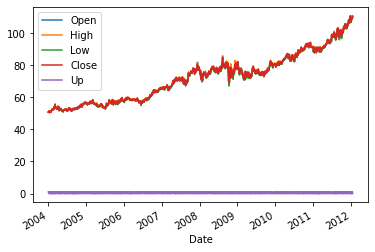

In [ ]:
train.plot()

短期的な株の動き

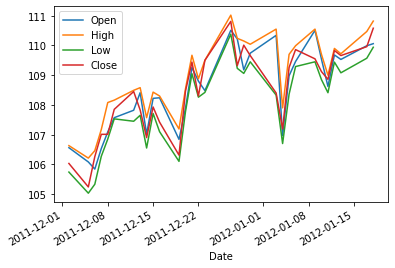

In [ ]:
from datetime import datetime
train.loc[train.index > datetime(2011,12,1),["Open","High","Low","Close"]].plot()

ローソク表示用変数Bodyの追加

In [ ]:
train["body"] = train["Open"] - train["Close"]
test["body"] = test["Open"] - test["Close"]

In [ ]:
print(train.head())
print()
print(test.head())

             Open   High    Low  Close  Up  body
Date                                            
2004-01-02  50.85  50.91  50.62  50.72   1  0.13
2004-01-05  50.75  50.84  50.61  50.79   1 -0.04
2004-01-06  50.87  51.26  50.86  51.15   1 -0.28
2004-01-07  51.45  51.54  51.29  51.51   0 -0.06
2004-01-08  51.15  51.33  51.02  51.28   0 -0.13

              Open    High     Low   Close  body
Date                                            
2012-01-19  110.79  110.82  109.96  110.39  0.40
2012-01-20  110.45  111.10  110.36  110.73 -0.28
2012-01-23  110.95  111.10  109.65  110.36  0.59
2012-01-24  110.16  110.16  108.13  108.39  1.77
2012-01-25  106.25  107.11  105.97  106.89 -0.64


test,trainを目的変数と説明変数に分解。裂けるチーズっぽくする

In [ ]:
X_data = train.drop(columns="Up",inplace = False)
y_data = train["Up"]

裂けるチーズを裂いたあとに包丁で切る。学習用、検証用、テスト用を6：2：2で分ける

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_data,y_data,test_size = 0.2,shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval,test_size = 0.25,shuffle = False)

裂いて切ったチーズの長さの確認

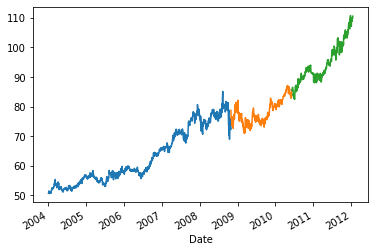

In [ ]:
X_train["Close"].plot()
X_val["Close"].plot()
X_test["Close"].plot()
plt.show()

ここまでで変数の確認と学習・検証・テスト用変数への分け方が終わった。
次に行うのはLSTMネットワークのための準備。

まずは5日分のデータを保持させるための必要な自作関数get_tをつくる

In [ ]:
#このget_tは低速版。したのもので再定義を。
def get_t(X, num_date):
  X_t_list=[]
  for i in range(len(X) - num_date +1):
    X_t = X.iloc[i:i+num_date,:]
    X_t_list.append(X_t)
  return X_t_list 

In [ ]:
# get_tの動作確認
num_date = 5
X_array_data = get_t(X_train,num_date=5)
X_array_data[0]

,Open,High,Low,Close,body
Date,,,,,
2004-01-02,50.85,50.91,50.62,50.72,0.13
2004-01-05,50.75,50.84,50.61,50.79,-0.04
2004-01-06,50.87,51.26,50.86,51.15,-0.28
2004-01-07,51.45,51.54,51.29,51.51,-0.06
2004-01-08,51.15,51.33,51.02,51.28,-0.13


In [ ]:
#高速版get_t
def get_t(X, num_date):
  X = np.array(X)
  X_t_list=[]
  for i in range(len(X) - num_date +1):
    X_t = X[i:i+num_date,:]
    X_t_list.append(X_t)
  return np.array(X_t_list) 

このまま5日間のデータを使うと、絶対値の大きいものの影響が強くなりすぎる。
そこで絶対値ではなく変化の度合いが大きいものが影響大きいように変更する。
要は、標準化。というやつである。

In [ ]:
#get_standardized
def get_standardized(X, num_date):
  X = np.array(X)
  X_t_list=[]
  for i in range(len(X) - num_date +1):
    X_t = X[i:i+num_date]
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X_t)
    X_t_list.append(X_standardized)
  return np.array(X_t_list) 

In [ ]:
#get_standardizedの動作確認
num_date = 5
X_array_data = get_standardized(X_train,num_date=5)
X_array_data[0]

array([[-0.64235239, -1.00983861, -1.01420225, -1.24303931,  1.54821589],
       [-1.03403068, -1.27558561, -1.05321003, -1.00786971,  0.270562  ],
       [-0.56401673,  0.3188964 , -0.07801556,  0.20157394, -1.53318467],
       [ 1.70771733,  1.38188441,  1.59931894,  1.4110176 ,  0.12024978],
       [ 0.53268247,  0.5846434 ,  0.5461089 ,  0.63831748, -0.405843  ]])

In [ ]:
#説明変数の5日分化

X_train_t = get_standardized(X_train,num_date)
X_val_t = get_standardized(X_val,num_date)
X_test_t = get_standardized(X_test,num_date)

print(X_train_t.shape)
print()
print(X_val_t.shape)
print()
print(X_test_t.shape)

(1211, 5, 5)

(401, 5, 5)

(402, 5, 5)


In [ ]:
# 目的変数の5日分化

y_train_t = y_train[num_date-1:]
y_val_t = y_val[num_date-1:]
y_test_t = y_test[num_date-1:]

print(y_train_t.shape)
print()
print(y_val_t.shape)
print()
print(y_test_t.shape)

(1211,)

(401,)

(402,)


# ここからはLSTMを用いたネットワークの定義から学習となる。

何もわからんなので、とりあえずQuestのステータスを丸パクリする。
初期値などを何から始めたらいいのかヒントが有ればいいのだが。

In [ ]:
#ネットワークの各層のサイズ

num_l1 = 100
num_l2 = 20
num_output = 1

#以下ネットワークの構築
model = Sequential()

#第1層
model.add(LSTM(units=num_l1,
               activation="tanh",
               batch_input_shape = (None,X_train_t.shape[1],X_train_t.shape[2])))
#第2層
model.add(Dense(num_l2,activation = "relu"))

#第3層
model.add(Dense(num_output,activation = "sigmoid"))

#ネットワークのコンパイル
model.compile(loss = "binary_crossentropy",optimizer= "adam",metrics=["accuracy"])

In [ ]:
# 学習

result = model.fit(X_train_t,y_train_t,epochs=80,batch_size=24,validation_data=(X_val_t,y_val_t))


Epoch 1/40
51/51 [==============================] - 0s 8ms/step - loss: 0.3599 - accuracy: 0.8159 - val_loss: 1.0021 - val_accuracy: 0.6035
Epoch 2/40
51/51 [==============================] - 0s 6ms/step - loss: 0.3625 - accuracy: 0.8241 - val_loss: 0.9805 - val_accuracy: 0.6209
Epoch 3/40
51/51 [==============================] - 0s 6ms/step - loss: 0.3582 - accuracy: 0.8249 - val_loss: 1.0256 - val_accuracy: 0.6234
Epoch 4/40
51/51 [==============================] - 0s 7ms/step - loss: 0.3281 - accuracy: 0.8340 - val_loss: 1.0893 - val_accuracy: 0.6060
Epoch 5/40
51/51 [==============================] - 0s 7ms/step - loss: 0.3281 - accuracy: 0.8423 - val_loss: 1.0721 - val_accuracy: 0.6035
Epoch 6/40
51/51 [==============================] - 0s 7ms/step - loss: 0.3146 - accuracy: 0.8464 - val_loss: 1.1155 - val_accuracy: 0.6160
Epoch 7/40
51/51 [==============================] - 0s 6ms/step - loss: 0.3202 - accuracy: 0.8448 - val_loss: 1.1340 - val_accuracy: 0.6234
Epoch 8/40
51/51 [==

In [ ]:
#学習履歴であるHistory型変数resultの通った履歴(history)は、辞書型である。そのkeysを調べることで、学習曲線がかける
print(result.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


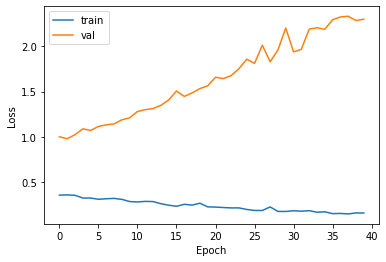

In [ ]:
#学習曲線の描画
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

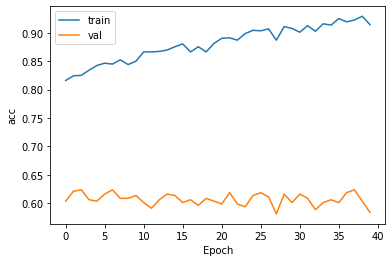

In [ ]:
#正解率の表示
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("acc")
plt.show()

検証の時点で汎化性能が低い！

In [ ]:
#評価データでの正解率
loss, accuracy = model.evaluate(X_test_t,y_test_t)
print("Test Acc:",accuracy)

13/13 [==============================] - 0s 2ms/step - loss: 2.7428 - accuracy: 0.5622
Test Acc: 0.5621890425682068


正解率がやっぱり低い！(
とはいえこのまま出しても2位にはなるが。(2020/12/11現在

正答率を上げるための方策として、特徴量を増やしてみる。
今回増やす特徴量は「どれくらい終わり値が上下したか」である。
前日比である。

Date
2004-01-02    0.000000
2004-01-05    0.001380
2004-01-06    0.007088
2004-01-07    0.007038
2004-01-08   -0.004465
Name: Close, dtype: float64
Date
2012-01-19    0.000000
2012-01-20    0.003080
2012-01-23   -0.003341
2012-01-24   -0.017851
2012-01-25   -0.013839
Name: Close, dtype: float64
Date
2004-01-02    0.000000
2004-01-05    0.001380
2004-01-06    0.007088
2004-01-07    0.007038
2004-01-08   -0.004465
Name: Rate, dtype: float64
Date
2012-01-19    0.000000
2012-01-20    0.003080
2012-01-23   -0.003341
2012-01-24   -0.017851
2012-01-25   -0.013839
Name: Rate, dtype: float64


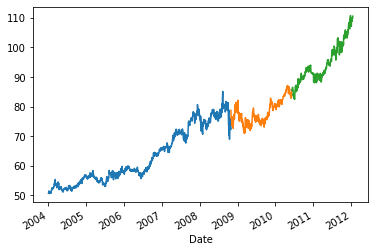

In [ ]:
#特徴量追加と再定義

df_rate_train = (train["Close"] - train["Close"].shift(1))/train["Close"].shift(1)
df_rate_train = df_rate_train.fillna(0)
print(df_rate_train.head())

df_rate_test = (test["Close"] - test["Close"].shift(1))/test["Close"].shift(1)
df_rate_test = df_rate_test.fillna(0)
print(df_rate_test.head())

train["Rate"] = df_rate_train
test["Rate"] = df_rate_test

X_data_added = train.drop(columns="Up",inplace = False)
y_data_added = train["Up"]

print(train["Rate"].head())
print(test["Rate"].head())

X_trainval,X_test, y_trainval,y_test = train_test_split(X_data_added,y_data_added,test_size = 0.2,shuffle = False)
X_train,X_val, y_train,y_val = train_test_split(X_trainval,y_trainval,test_size = 0.25,shuffle = False)

X_train["Close"].plot()
X_val["Close"].plot()
X_test["Close"].plot()
plt.show()

In [ ]:
X_train["Rate"].head()

Date
2004-01-02    0.000000
2004-01-05    0.001380
2004-01-06    0.007088
2004-01-07    0.007038
2004-01-08   -0.004465
                ...   
2008-10-22   -0.024443
2008-10-23    0.028634
2008-10-24   -0.025964
2008-10-27   -0.007557
2008-10-28    0.045549
Name: Rate, Length: 1215, dtype: float64

In [ ]:
#説明変数の5日分化

X_train_t = get_standardized(X_train,num_date)
X_val_t = get_standardized(X_val,num_date)
X_test_t = get_standardized(X_test,num_date)

print(X_train_t.shape)
print()
print(X_val_t.shape)
print()
print(X_test_t.shape)

(1211, 5, 6)

(401, 5, 6)

(402, 5, 6)


In [ ]:
# 目的変数の5日分化

y_train_t = y_train[num_date-1:]
y_val_t = y_val[num_date-1:]
y_test_t = y_test[num_date-1:]

print(y_train_t.shape)
print()
print(y_val_t.shape)
print()
print(y_test_t.shape)

(1211,)

(401,)

(402,)


In [ ]:
#ネットワークの各層のサイズ

num_l1 = 100
num_l2 = 20
num_output = 1

#以下ネットワークの構築
model = Sequential()



#第1層
model.add(LSTM(units=num_l1,
               activation="tanh",
               batch_input_shape = (None,X_train_t.shape[1],X_train_t.shape[2])))
#第2層
model.add(Dense(num_l2,activation = "relu"))

#第3層
model.add(Dense(num_output,activation = "sigmoid"))

#ネットワークのコンパイル
model.compile(loss = "binary_crossentropy",optimizer= "adam",metrics=["accuracy"])

# 学習

result = model.fit(X_train_t,y_train_t,epochs=40,batch_size=24,validation_data=(X_val_t,y_val_t))


Epoch 1/40
51/51 [==============================] - 1s 16ms/step - loss: 0.6874 - accuracy: 0.5359 - val_loss: 0.6723 - val_accuracy: 0.5935
Epoch 2/40
51/51 [==============================] - 0s 7ms/step - loss: 0.6725 - accuracy: 0.5723 - val_loss: 0.6489 - val_accuracy: 0.6234
Epoch 3/40
51/51 [==============================] - 0s 7ms/step - loss: 0.6535 - accuracy: 0.6094 - val_loss: 0.6287 - val_accuracy: 0.6459
Epoch 4/40
51/51 [==============================] - 0s 6ms/step - loss: 0.6462 - accuracy: 0.6160 - val_loss: 0.6260 - val_accuracy: 0.6459
Epoch 5/40
51/51 [==============================] - 0s 7ms/step - loss: 0.6414 - accuracy: 0.6317 - val_loss: 0.6241 - val_accuracy: 0.6559
Epoch 6/40
51/51 [==============================] - 0s 6ms/step - loss: 0.6388 - accuracy: 0.6350 - val_loss: 0.6208 - val_accuracy: 0.6584
Epoch 7/40
51/51 [==============================] - 0s 6ms/step - loss: 0.6352 - accuracy: 0.6375 - val_loss: 0.6221 - val_accuracy: 0.6534
Epoch 8/40
51/51 [=

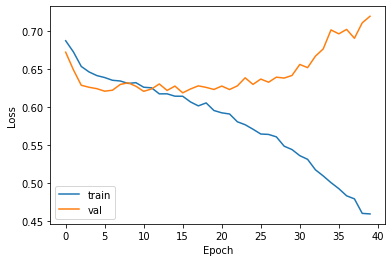

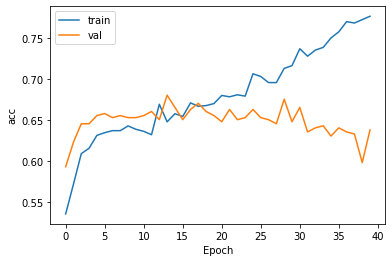

In [ ]:
#学習曲線の描画
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
#正解率の表示
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("acc")
plt.show()

In [ ]:
#評価データでの正解率
loss, accuracy = model.evaluate(X_test_t,y_test_t)
print("Test Acc:",accuracy)

13/13 [==============================] - 0s 3ms/step - loss: 0.8585 - accuracy: 0.5572
Test Acc: 0.5572139024734497


正解率がさらに低下。とりあえず進んでDropoutを実装する

In [ ]:
#ネットワークの各層のサイズ

num_l1 = 100
num_l2 = 20
num_output = 1

#DropoutRate
dropout_rate = 0.4
#以下ネットワークの構築
model = Sequential()



#第1層
model.add(LSTM(units=num_l1,
               activation="tanh",
               batch_input_shape = (None,X_train_t.shape[1],X_train_t.shape[2])))
model.add(Dropout(dropout_rate))
#第2層
model.add(Dense(num_l2,activation = "relu"))
model.add(Dropout(dropout_rate))

#第3層
model.add(Dense(num_output,activation = "sigmoid"))

#ネットワークのコンパイル
model.compile(loss = "binary_crossentropy",optimizer= "adam",metrics=["accuracy"])

# 学習

result = model.fit(X_train_t,y_train_t,epochs=40,batch_size=24,validation_data=(X_val_t,y_val_t))


Epoch 1/40
51/51 [==============================] - 1s 17ms/step - loss: 0.6884 - accuracy: 0.5516 - val_loss: 0.6777 - val_accuracy: 0.5910
Epoch 2/40
51/51 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.5491 - val_loss: 0.6672 - val_accuracy: 0.5985
Epoch 3/40
51/51 [==============================] - 0s 8ms/step - loss: 0.6727 - accuracy: 0.5582 - val_loss: 0.6557 - val_accuracy: 0.6284
Epoch 4/40
51/51 [==============================] - 0s 7ms/step - loss: 0.6645 - accuracy: 0.5904 - val_loss: 0.6394 - val_accuracy: 0.6484
Epoch 5/40
51/51 [==============================] - 0s 7ms/step - loss: 0.6522 - accuracy: 0.6168 - val_loss: 0.6319 - val_accuracy: 0.6459
Epoch 6/40
51/51 [==============================] - 0s 7ms/step - loss: 0.6569 - accuracy: 0.6160 - val_loss: 0.6256 - val_accuracy: 0.6484
Epoch 7/40
51/51 [==============================] - 0s 6ms/step - loss: 0.6497 - accuracy: 0.6152 - val_loss: 0.6251 - val_accuracy: 0.6584
Epoch 8/40
51/51 [=

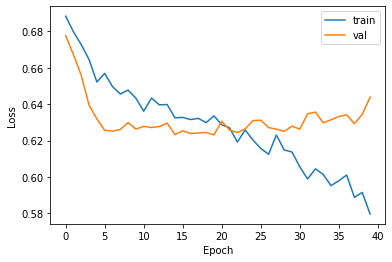

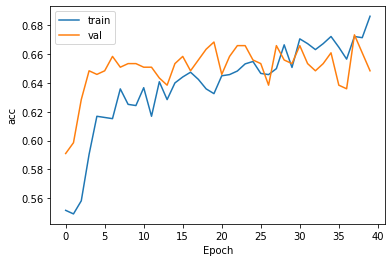

13/13 [==============================] - 0s 2ms/step - loss: 0.7116 - accuracy: 0.5945
Test Acc: 0.5945273637771606


In [ ]:
#学習曲線の描画
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
#正解率の表示
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("acc")
plt.show()

#評価データでの正解率
loss, accuracy = model.evaluate(X_test_t,y_test_t)
print("Test Acc:",accuracy)

40エポックぐらいが過学習が起きるまえっぽいが、次に進む。
改めX_testデータで予測を行う。出力は0 or 1。


In [ ]:
y_test

Date
2010-06-10    1
2010-06-11    1
2010-06-14    1
2010-06-15    1
2010-06-16    0
             ..
2012-01-11    1
2012-01-12    0
2012-01-13    1
2012-01-17    1
2012-01-18    0
Name: Up, Length: 406, dtype: int64

In [ ]:
pred_prob = model.predict(X_test_t)
pred_prob[:10]
pred = np.round(pred_prob[:])
pred[:10]
accuracy = accuracy_score(y_true = y_test_t,y_pred = pred)
print(accuracy)

In [ ]:
pred_prob = model.predict(X_test_t)
pred_prob[:10]
pred = np.round(pred_prob[:])
pred[:10]
accuracy = accuracy_score(y_true = y_test_t,y_pred = pred)
print(accuracy)

In [ ]:
#以下本番用テストデータの標準化とかから


In [ ]:
# 目的変数の5日分化(不要では？)
X_test_t = get_standardized(test,num_date)
print(X_test_t.shape)
print()
print(test.shape)

(1196, 5, 6)

(1200, 6)


In [ ]:
print(X_test.shape)
pred_sub = model.predict(X_test_t)

(1200, 6)


本番データでの予測ができたら、提出用ファイルをつくる。
今回は[日付、1 or 0]の200行が必要。

まずは提出用の日付を作る

In [ ]:
test.index

DatetimeIndex(['2012-01-19', '2012-01-20', '2012-01-23', '2012-01-24',
               '2012-01-25', '2012-01-26', '2012-02-02', '2012-02-03',
               '2012-02-06', '2012-02-07',
               ...
               '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-09',
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23'],
              dtype='datetime64[ns]', name='Date', length=1200, freq=None)



> 今回提出ファイルの日付がYYYY/MM/(1桁)/DD(1桁)の形式のため、Formatを変更する。
DatetimeIndexのフォーマットについては以下サイトを参考にしながら半信半疑でやったが、うまく行った。ただ、一度X_testのインデックスをかえたらtestのインデックスも変わったように見えたし再読み込みしたのでそこは謎が残るが。とにかく0埋めの%mにたいして0埋めないものは%-mであった。

これはクソッタレExcelのせいで表記が揺れていただけだった。
Formatはyyyy-mm-ddであった。FXXX。




参考
https://stackoverrun.com/ja/q/12908501
https://python.keicode.com/lang/format-datetime.php#2

In [ ]:
X_test = test
#X_test.index = X_test.index.format(formatter=lambda t: f'{t:%Y/%-m/%-d}')
X_test_picked = X_test.index[5::6]
print(X_test_picked)
print(X_test_picked.shape)

DatetimeIndex(['2012-01-26', '2012-02-09', '2012-02-24', '2012-03-09',
               '2012-03-23', '2012-04-09', '2012-04-23', '2012-05-07',
               '2012-05-21', '2012-06-05',
               ...
               '2019-08-15', '2019-08-29', '2019-09-13', '2019-09-27',
               '2019-10-11', '2019-10-25', '2019-11-08', '2019-11-22',
               '2019-12-09', '2019-12-23'],
              dtype='datetime64[ns]', name='Date', length=200, freq=None)
(200,)


In [ ]:
pred_sub[:10]

array([[0.97362316],
       [0.44604045],
       [0.47462058],
       [0.46643993],
       [0.02054283],
       [0.8528793 ],
       [0.04644278],
       [0.6104676 ],
       [0.8166307 ],
       [0.5002234 ]], dtype=float32)

In [ ]:
pred_sub.shape

(1196, 1)

1196件のデータのうち、提出に必要なものは、6日ごとのデータ。
X_test_t(本番予測データtestを5日化してpredict通したもの)は5日めのデータから始まるため、2番目のデータから6区切りで値をひろう必要がある。

今回は提出するファイルがたまたま6日に1度のデータだったので良かったが、
5日分のデータ読み込みしたあと、それを使うような場合はどうすればいいのかはわからぬまま。偉い人教えてほしい。

In [ ]:
pred_sub_picked = pred_sub[1::6]

In [ ]:
pred_sub_picked.shape

(200, 1)

In [ ]:
# 予測値を0 or 1に丸める
# roundをかけるとfloat64で出てくるのをさらにastypeでdtypeをint64に変換
pred_sub_rounded = np.round(pred_sub_picked[:])
pred_sub_rounded = pred_sub_rounded.astype("int64")

In [ ]:
pred_sub_rounded.dtype

dtype('int64')

In [ ]:
sub = submit

indexはindexで書き換えられるが、今回はいらなかった機運が強い。まぁ書き換えたが。

In [ ]:
sub.index = X_test.index[5::6]

In [ ]:
sub["Up"] = pred_sub_rounded

In [ ]:
sub

,Up
Date,
2012-01-26,0
2012-02-09,1
2012-02-24,0
2012-03-09,0
2012-03-23,0
...,...
2019-10-25,1
2019-11-08,1
2019-11-22,0


In [ ]:
sub.to_csv("submission.csv",index = True, header = False)
print("Submited") 

Submited


In [ ]:
!signate submit -c 409 submission.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.
